#Main Architecture

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

class Model_Down(nn.Module):
    """
    Convolutional (Downsampling) Blocks.

    nd = Number of Filters
    kd = Kernel size

    """
    def __init__(self,in_channels, nd = 128, kd = 3, padding = 1, stride = 2):
        super(Model_Down,self).__init__()
        self.padder = nn.ReflectionPad2d(padding)
        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = nd, kernel_size = kd, stride = stride)
        self.bn1 = nn.BatchNorm2d(nd)

        self.conv2 = nn.Conv2d(in_channels = nd, out_channels = nd, kernel_size = kd, stride = 1)
        self.bn2 = nn.BatchNorm2d(nd)

        self.relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.padder(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.padder(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x


class Model_Skip(nn.Module):
    """

    Skip Connections

    ns = Number of filters
    ks = Kernel size

    """
    def __init__(self,in_channels = 128, ns = 4, ks = 1, padding = 0, stride = 1):
        super(Model_Skip, self).__init__()
        self.conv = nn.Conv2d(in_channels = in_channels, out_channels = ns, kernel_size = ks, stride = stride, padding = padding)
        self.bn = nn.BatchNorm2d(ns)
        self.relu = nn.LeakyReLU()

    def forward(self,x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Model_Up(nn.Module):
    """
    Convolutional (Downsampling) Blocks.

    nd = Number of Filters
    kd = Kernel size

    """
    def __init__(self, in_channels = 132, nu = 128, ku = 3, padding = 1):
        super(Model_Up, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.padder = nn.ReflectionPad2d(padding)
        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = nu, kernel_size = ku, stride = 1, padding = 0)
        self.bn2 = nn.BatchNorm2d(nu)

        self.conv2 =  nn.Conv2d(in_channels = nu, out_channels = nu, kernel_size = 1, stride = 1, padding = 0) #According to supmat.pdf ku = 1 for second layer
        self.bn3 = nn.BatchNorm2d(nu)

        self.relu = nn.LeakyReLU()

    def forward(self,x):
        x = self.bn1(x)
        x = self.padder(x)
        x = self.conv1(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = F.interpolate(x, scale_factor = 2, mode = 'bilinear', align_corners = True)
        return x


class Model(nn.Module):
    def __init__(self, length = 5, in_channels = 32, nu = [128,128,128,128,128] , nd =
                    [128,128,128,128,128], ns = [4,4,4,4,4], ku = [3,3,3,3,3], kd = [3,3,3,3,3], ks = [1,1,1,1,1]):
        super(Model,self).__init__()
        assert length == len(nu), 'Hyperparameters do not match network depth.'

        self.length = length

        self.downs = nn.ModuleList([Model_Down(in_channels = nd[i-1], nd = nd[i], kd = kd[i]) if i != 0 else
                                        Model_Down(in_channels = in_channels, nd = nd[i], kd = kd[i]) for i in range(self.length)])

        self.skips = nn.ModuleList([Model_Skip(in_channels = nd[i], ns = ns[i], ks = ks[i]) for i in range(self.length)])

        self.ups = nn.ModuleList([Model_Up(in_channels = ns[i]+nu[i+1], nu = nu[i], ku = ku[i]) if i != self.length-1 else
                                        Model_Up(in_channels = ns[i], nu = nu[i], ku = ku[i]) for i in range(self.length-1,-1,-1)]) #Elements ordered backwards

        self.conv_out = nn.Conv2d(nu[0],3,1,padding = 0)
        self.sigm = nn.Sigmoid()

    def forward(self,x):
        s = [] #Skip Activations

        #Downpass
        for i in range(self.length):
            x = self.downs[i].forward(x)
            s.append(self.skips[i].forward(x))

        #Uppass
        for i in range(self.length):
            if (i == 0):
                x = self.ups[i].forward(s[-1])
            else:
                x = self.ups[i].forward(torch.cat([x,s[self.length-1-i]],axis = 1))

        x = self.sigm(self.conv_out(x)) #Squash to RGB ([0,1]) format
        return x


## Model Summary

In [133]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model = Model().to(device)
from torchsummary import summary
summary(model, (32,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1         [-1, 32, 514, 514]               0
            Conv2d-2        [-1, 128, 256, 256]          36,992
       BatchNorm2d-3        [-1, 128, 256, 256]             256
         LeakyReLU-4        [-1, 128, 256, 256]               0
   ReflectionPad2d-5        [-1, 128, 258, 258]               0
            Conv2d-6        [-1, 128, 256, 256]         147,584
       BatchNorm2d-7        [-1, 128, 256, 256]             256
         LeakyReLU-8        [-1, 128, 256, 256]               0
            Conv2d-9          [-1, 4, 256, 256]             516
      BatchNorm2d-10          [-1, 4, 256, 256]               8
        LeakyReLU-11          [-1, 4, 256, 256]               0
  ReflectionPad2d-12        [-1, 128, 258, 258]               0
           Conv2d-13        [-1, 128, 128, 128]         147,584
      BatchNorm2d-14        [-1, 128, 1

# Inpainting

## Preprocessing

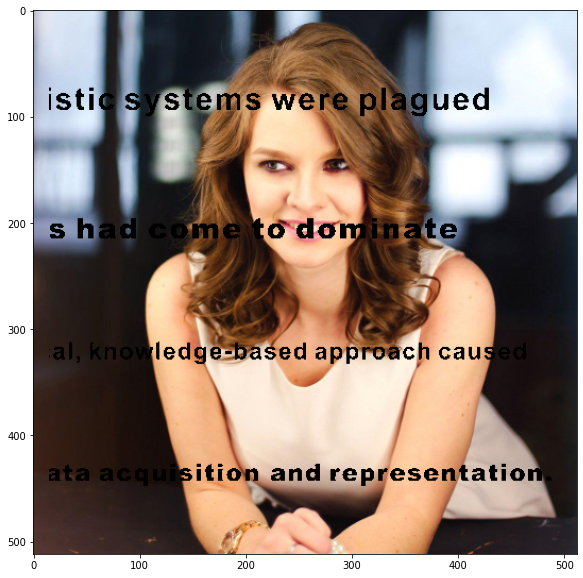

In [137]:
im = Image.open('kate.png')
maskim = Image.open('kate_mask.png')
im = im.convert('RGB')
maskim = maskim.convert('1')

im_np = np.array(im)
mask_np = np.array(maskim,dtype = float)
mask_np = (np.repeat(mask_np[:,:,np.newaxis], 3, axis = 2)/255)

fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(im_np*mask_np)

mask_tensor = torch.from_numpy(mask_np).permute(2,0,1)
im_tensor = torch.from_numpy(im_np).permute(2,0,1)

im_masked_tensor = ((mask_tensor*im_tensor).unsqueeze(0)/255).cuda()
mask_tensor = mask_tensor.unsqueeze(0).cuda()

## Training Loop

In [0]:
#Initialize model params

z = (0.05) * torch.rand((1,32,512,512), device = "cuda")

#Meshgrid Input
#sym = np.arange(0,512)
#xv, yv = np.meshgrid(sym,sym)
#xv = xv/(255.0)
#yv = yv/(255.0)
#z =np.stack([xv,yv])
#z = torch.from_numpy(z)
#z = torch.tensor(z.unsqueeze(0), device = 'cuda', dtype = torch.float32)

net = Model()
optimizer = torch.optim.Adam(net.parameters(),lr = 0.0075)

use_gpu = torch.cuda.is_available()

if use_gpu:
    net = net.cuda()

EPOCH: 0
LOSS: 1.8356626947530545e-06

EPOCH: 100
LOSS: 6.157910097953064e-08

EPOCH: 200
LOSS: 3.5619075330488596e-08

EPOCH: 300
LOSS: 2.557663625337435e-08

EPOCH: 400
LOSS: 2.1827357829997648e-08

EPOCH: 500
LOSS: 1.769764843614794e-08

EPOCH: 600
LOSS: 1.5497726485539617e-08

EPOCH: 700
LOSS: 1.4073046690060186e-08

EPOCH: 800
LOSS: 1.2741288186423429e-08

EPOCH: 900
LOSS: 1.1969785621400223e-08

EPOCH: 1000
LOSS: 1.0677283812671851e-08

EPOCH: 1100
LOSS: 1.0773934875901352e-08

EPOCH: 1200
LOSS: 9.429687660859503e-09

EPOCH: 1300
LOSS: 8.998965967391118e-09

EPOCH: 1400
LOSS: 8.609513216133845e-09

EPOCH: 1500
LOSS: 8.765947892281459e-09

EPOCH: 1600
LOSS: 8.60251611117109e-09

EPOCH: 1700
LOSS: 8.013295984733671e-09

EPOCH: 1800
LOSS: 7.82008484990977e-09

EPOCH: 1900
LOSS: 7.781365284043573e-09

EPOCH: 2000
LOSS: 7.671288591876033e-09

EPOCH: 2100
LOSS: 6.943341628972332e-09

EPOCH: 2200
LOSS: 6.644382465272192e-09

EPOCH: 2300
LOSS: 6.544951828911033e-09

EPOCH: 2400
LOSS: 6.4

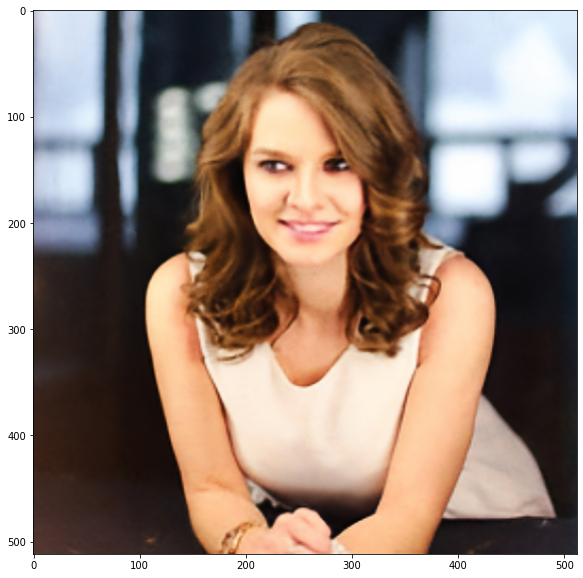

In [146]:
for epoch in range(4000):
    
    #torch.save(net.state_dict(),'model')
    
    optimizer.zero_grad()
    output = net.forward(z)
    loss = F.mse_loss(output*mask_tensor, im_masked_tensor)

    if (epoch % 100 == 0):
      print('EPOCH: ' + str(epoch))
      print('LOSS: ' + str(loss.item()), end ='\n\n')

    loss.backward()
    optimizer.step()

    z = z + (1/30)*torch.randn_like(z)

fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(output.cpu().view(3,512,512).permute(1,2,0).detach().numpy())
